# IMDB Movies

## Overview
- For this project, produce a MySQL database on Movies from a subset of IMDB's publicly available dataset. Ultimately, you will use this database to analyze what makes a movie successful and will provide recommendations to the stakeholder on how to make a successful movie.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, json
import tmdbsimple as tmdb
from tqdm.notebook import tqdm_notebook

In [2]:
basics_url= 'https://datasets.imdbws.com/title.basics.tsv.gz'

akas_url= 'https://datasets.imdbws.com/title.akas.tsv.gz'

ratings_url= 'https://datasets.imdbws.com/title.ratings.tsv.gz'

In [3]:
basics = pd.read_csv(basics_url, sep='\t', low_memory=False)

akas = pd.read_csv(akas_url, sep='\t', low_memory= False)

ratings = pd.read_csv(ratings_url, sep='\t', low_memory= False)

## Cleaning the Data

In [4]:
basics.replace({'\\N':np.nan}, inplace=True)

akas.replace({'\\N':np.nan}, inplace= True)

ratings.replace({'\\N':np.nan}, inplace= True)

### Basics

In [5]:
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,NaN,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,NaN,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,NaN,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,NaN,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,NaN,1,"Comedy,Short"


In [6]:
basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9995235 entries, 0 to 9995234
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 686.3+ MB


In [7]:
basics.dropna(subset = ['startYear'], inplace=True)
basics.dropna(subset = ['runtimeMinutes'], inplace=True)
basics.dropna(subset = ['genres'], inplace=True)

In [8]:
basics = basics[basics.titleType == 'movie']
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,NaN,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,NaN,100,"Documentary,News,Sport"
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,NaN,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,NaN,90,Drama
672,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908,NaN,120,"Adventure,Fantasy"


In [9]:
basics = basics.astype({'startYear': float})

In [10]:
basics = basics[basics.startYear > 1999]

In [11]:
basics = basics[basics.startYear < 2022]

In [12]:
basics['startYear'].unique()

array([2021., 2001., 2020., 2018., 2005., 2002., 2009., 2017., 2000.,
       2006., 2004., 2008., 2007., 2003., 2012., 2010., 2013., 2011.,
       2015., 2016., 2014., 2019.])

In [13]:
is_documentary = basics['genres'].str.contains('documentary',case=False)
basics = basics[~is_documentary]

### AKAs

In [14]:
akas.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,NaN,imdbDisplay,NaN,0
1,tt0000001,2,Carmencita,DE,NaN,NaN,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,NaN,imdbDisplay,NaN,0
3,tt0000001,4,Καρμενσίτα,GR,NaN,imdbDisplay,NaN,0
4,tt0000001,5,Карменсита,RU,NaN,imdbDisplay,NaN,0


In [15]:
akas = akas[akas.region == 'US']
akas.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
5,tt0000001,6,Carmencita,US,NaN,imdbDisplay,NaN,0
14,tt0000002,7,The Clown and His Dogs,US,NaN,NaN,literal English title,0
33,tt0000005,10,Blacksmith Scene,US,NaN,imdbDisplay,NaN,0
36,tt0000005,1,Blacksmithing Scene,US,NaN,alternative,NaN,0
41,tt0000005,6,Blacksmith Scene #1,US,NaN,alternative,NaN,0


In [16]:
keepers = basics['tconst'].isin(akas['titleId'])
keepers

34803       True
61115       True
67667       True
86794       True
93931       True
           ...  
9994908     True
9994917     True
9994956    False
9995001     True
9995085    False
Name: tconst, Length: 138771, dtype: bool

In [17]:
basics = basics[keepers]
basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
34803,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
61115,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
67667,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
86794,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
93931,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama
...,...,...,...,...,...,...,...,...,...
9994373,tt9914942,movie,Life Without Sara Amat,La vida sense la Sara Amat,0,2019.0,NaN,74,Drama
9994768,tt9915872,movie,The Last White Witch,My Girlfriend is a Wizard,0,2019.0,NaN,97,"Comedy,Drama,Fantasy"
9994908,tt9916170,movie,The Rehearsal,O Ensaio,0,2019.0,NaN,51,Drama
9994917,tt9916190,movie,Safeguard,Safeguard,0,2020.0,NaN,95,"Action,Adventure,Thriller"


### Ratings

In [18]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1986
1,tt0000002,5.8,265
2,tt0000003,6.5,1845
3,tt0000004,5.5,178
4,tt0000005,6.2,2627


In [19]:
keepers_rate = ratings['tconst'].isin(akas['titleId'])
keepers_rate

0           True
1           True
2          False
3          False
4           True
           ...  
1328579    False
1328580    False
1328581    False
1328582    False
1328583    False
Name: tconst, Length: 1328584, dtype: bool

In [20]:
ratings = ratings[keepers_rate]
ratings

,tconst,averageRating,numVotes
0,tt0000001,5.7,1986
1,tt0000002,5.8,265
4,tt0000005,6.2,2627
5,tt0000006,5.1,182
6,tt0000007,5.4,820
...,...,...,...
1328545,tt9916200,8.1,230
1328546,tt9916204,8.2,264
1328553,tt9916348,8.3,18
1328554,tt9916362,6.4,5413


In [21]:
import os
os.makedirs('Data/',exist_ok=True) 
os.listdir("Data/")

['title_basics.csv.gz', 'title_akas.csv.gz', 'title_ratings.csv.gz']

In [22]:
basics.to_csv("Data/title_basics.csv.gz",compression='gzip',index=False)

In [23]:
basics = pd.read_csv("Data/title_basics.csv.gz", low_memory = False)
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama


In [24]:
akas.to_csv("Data/title_akas.csv.gz",compression='gzip',index=False)

In [25]:
akas = pd.read_csv("Data/title_akas.csv.gz", low_memory = False)
akas.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,6,Carmencita,US,NaN,imdbDisplay,NaN,0.0
1,tt0000002,7,The Clown and His Dogs,US,NaN,NaN,literal English title,0.0
2,tt0000005,10,Blacksmith Scene,US,NaN,imdbDisplay,NaN,0.0
3,tt0000005,1,Blacksmithing Scene,US,NaN,alternative,NaN,0.0
4,tt0000005,6,Blacksmith Scene #1,US,NaN,alternative,NaN,0.0


In [26]:
ratings.to_csv("Data/title_ratings.csv.gz",compression='gzip',index=False)

In [27]:
ratings = pd.read_csv("Data/title_ratings.csv.gz", low_memory = False)
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1986
1,tt0000002,5.8,265
2,tt0000005,6.2,2627
3,tt0000006,5.1,182
4,tt0000007,5.4,820


In [28]:
with open('/Users/willrodemoyer/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
    
login.keys()

dict_keys(['API Key'])

In [29]:
tmdb.API_KEY =  login['API Key']

In [32]:
def get_movie_with_rating(movie_id):
    """Adapted from source= https://github.com/celiao/tmdbsimple"""
    # Get the movie object for the current id
    movie= tmdb.Movies(movie_id)
    
    # save the .info .releases dictionaries
    info = movie.info()
    
    releases = movie.releases()
    # Loop thru countries in releases
    for c in releases['countries']:
        # if the country abbr. == US
        if c['iso_3166_1'] == 'US':
            # save a 'certification' key if info with the certification
            info['certification'] = c['certification']
            
    return info
        

In [33]:
test = get_movie_with_rating("tt0848228")
test

{'adult': False,
 'backdrop_path': '/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg',
 'belongs_to_collection': {'id': 86311,
  'name': 'The Avengers Collection',
  'poster_path': '/yFSIUVTCvgYrpalUktulvk3Gi5Y.jpg',
  'backdrop_path': '/zuW6fOiusv4X9nnW3paHGfXcSll.jpg'},
 'budget': 220000000,
 'genres': [{'id': 878, 'name': 'Science Fiction'},
  {'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'https://www.marvel.com/movies/the-avengers',
 'id': 24428,
 'imdb_id': 'tt0848228',
 'original_language': 'en',
 'original_title': 'The Avengers',
 'overview': 'When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of the international peacekeeping agency known as S.H.I.E.L.D., finds himself in need of a team to pull the world back from the brink of disaster. Spanning the globe, a daring recruitment effort begins!',
 'popularity': 147.661,
 'poster_path': '/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg',
 'production_companies': [{'id': 420,
   'logo_path

In [34]:
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['title_basics.csv.gz', 'title_akas.csv.gz', 'title_ratings.csv.gz']

In [35]:
def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [37]:
basics.head(3)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama


In [38]:
YEARS_TO_GET = [2000,2001]

In [39]:
errors = [ ]

In [55]:
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0): 
    
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    
    # Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
    
    # If it does not exist: create it
    if file_exists == False:
    # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
    
    #Saving new year as the current df
    df = basics.loc[ basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    
    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)
    
    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    
    #Get index and movie id from list
    # INNER Loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve then data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
            
        except Exception as e:
            errors.append([movie_id, e])
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

print(f"- Total errors: {len(errors)}")

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2000:   0%|          | 0/1455 [00:00<?, ?it/s]

Movies from 2001:   0%|          | 0/1577 [00:00<?, ?it/s]

- Total errors: 449


In [65]:
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
10,tt0114447,movie,The Silent Force,The Silent Force,0,2001.0,NaN,90,Action
14,tt0116916,movie,The Lord Protector,The Lord Protector,0,2001.0,NaN,101,"Action,Adventure,Fantasy"
18,tt0118589,movie,Glitter,Glitter,0,2001.0,NaN,104,"Drama,Music,Romance"
19,tt0118652,movie,The Attic Expeditions,The Attic Expeditions,0,2001.0,NaN,100,"Comedy,Horror,Mystery"


In [91]:
df00= pd.read_csv('Data/final_tmdb_data_2000.csv.gz')
df00.shape

(1248, 26)

In [90]:
df01= pd.read_csv('Data/final_tmdb_data_2001.csv.gz')
df01.shape

(1337, 26)

In [87]:
df1= pd.concat([df00, df01], axis=0)
df1.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,"{'id': 1131062, 'name': 'Wong Kar-Wai’s Love T...",150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,14204632.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.111,2250.0,PG


In [89]:
df1.shape

(2585, 26)

In [95]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2585 entries, 0 to 1336
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                2585 non-null   object 
 1   adult                  2583 non-null   float64
 2   backdrop_path          1422 non-null   object 
 3   belongs_to_collection  210 non-null    object 
 4   budget                 2583 non-null   float64
 5   genres                 2583 non-null   object 
 6   homepage               171 non-null    object 
 7   id                     2583 non-null   float64
 8   original_language      2583 non-null   object 
 9   original_title         2583 non-null   object 
 10  overview               2537 non-null   object 
 11  popularity             2583 non-null   float64
 12  poster_path            2338 non-null   object 
 13  production_companies   2583 non-null   object 
 14  production_countries   2583 non-null   object 
 15  rele

In [104]:
print(df1[df1.index.duplicated()])

        imdb_id  adult                     backdrop_path  \
1     tt0035423    0.0  /hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg   
2     tt0114447    0.0                               NaN   
3     tt0116916    0.0  /rFpHBidSlhjflmnLu7BZilyKeQR.jpg   
4     tt0118589    0.0  /9NZAirJahVilTiDNCHLFcdkwkiy.jpg   
5     tt0118652    0.0  /mWxJEFRMvkG4UItYJkRDMgWQ08Y.jpg   
...         ...    ...                               ...   
1243  tt0389418    0.0                               NaN   
1244  tt0392759    0.0                               NaN   
1245  tt0396551    0.0                               NaN   
1246  tt0403665    0.0                               NaN   
1247  tt0403951    0.0                               NaN   

     belongs_to_collection      budget  \
1                      NaN  48000000.0   
2                      NaN         0.0   
3                      NaN         0.0   
4                      NaN  22000000.0   
5                      NaN   1000000.0   
...                    ... 

In [105]:
df1 = df1.loc[~df1.index.duplicated(), :]

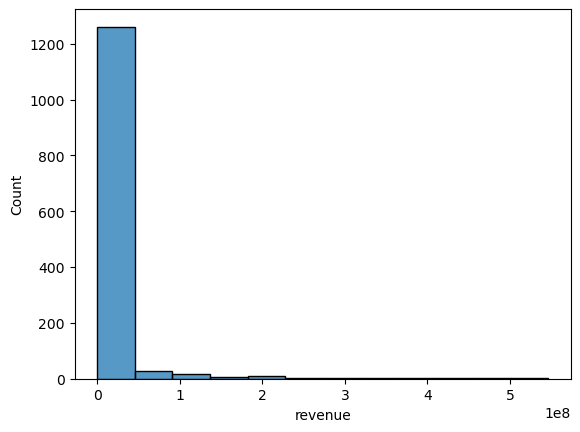

In [107]:
ax = sns.histplot(data= df1,x= 'revenue');

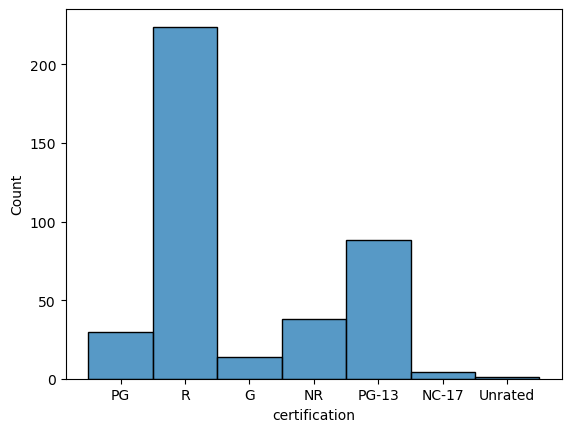

In [106]:
ax = sns.histplot(data= df1,x= 'certification');